In [1]:
!pip install tensorflow==2.9.1

  Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.13.0
    Uninstalling tensorflow-2.13.0:
      Successfully uninstalled tensorflow-2.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.5.0 requires tensorflow~=2.13.0, but you have tensorflow 2.9.1 which is incompatible.
tensorflow-serving-api 2.13.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.
tensorflow-serving-api 2.13.0 requires tensorflow<3,>=2.13.0, but you have tensorflow 2.9.1 which is incompatible.
tensorflow-text 2.13.0 requires tensorflow<2.14,>=2.13.0; platform_machine != "arm64" or 

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [21]:
# Generate data paths with labels
data_dir1 = '/kaggle/input/weather-dataset/dataset'
data_dir2 = '/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset'
filepaths = []
labels = []

folds1 = os.listdir(data_dir1)
folds2 = os.listdir(data_dir2)
for fold in folds1:
    foldpath = os.path.join(data_dir1, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
        
for fold in folds2:
    foldpath = os.path.join(data_dir2, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

#fog,lightning , rain , sand

In [22]:
#drop labels
drop_labels = ['Sunrise','dew','frost','glaze','hail','rainbow','rime']
df = df[~df['labels'].isin(drop_labels)]

In [23]:
df['labels'] = df['labels'].replace('Rain','rain')
label_counts = df['labels'].value_counts()
print(label_counts)

labels
fogsmog      851
rain         741
sandstorm    692
snow         621
lightning    377
Cloudy       300
Shine        253
Name: count, dtype: int64


In [24]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

# 데이터 증강 scale shift 기법 사용 not rotate 

In [25]:
label_counts = train_df['labels'].value_counts()
print(label_counts)

labels
fogsmog      690
rain         589
sandstorm    548
snow         489
lightning    313
Cloudy       243
Shine        196
Name: count, dtype: int64


In [26]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [27]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
        print (list(train_df['labels'].value_counts()) )
    return train_df 

In [28]:
max_samples= 500
min_samples=0
column='labels'
working_dir = r'./'
img_size=(224,224)
train_df=balance(train_df,max_samples, min_samples, column, working_dir, img_size)

Original Number of classes in dataframe:  7
[500, 500, 500, 489, 313, 243, 196]
Found 313 validated image filenames.
Found 196 validated image filenames.
Found 489 validated image filenames.
Found 243 validated image filenames.
Total Augmented images created=  759
[500, 500, 500, 500, 500, 500, 500]


In [30]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 3500 validated image filenames belonging to 7 classes.
Found 460 validated image filenames belonging to 7 classes.
Found 307 validated image filenames belonging to 7 classes.


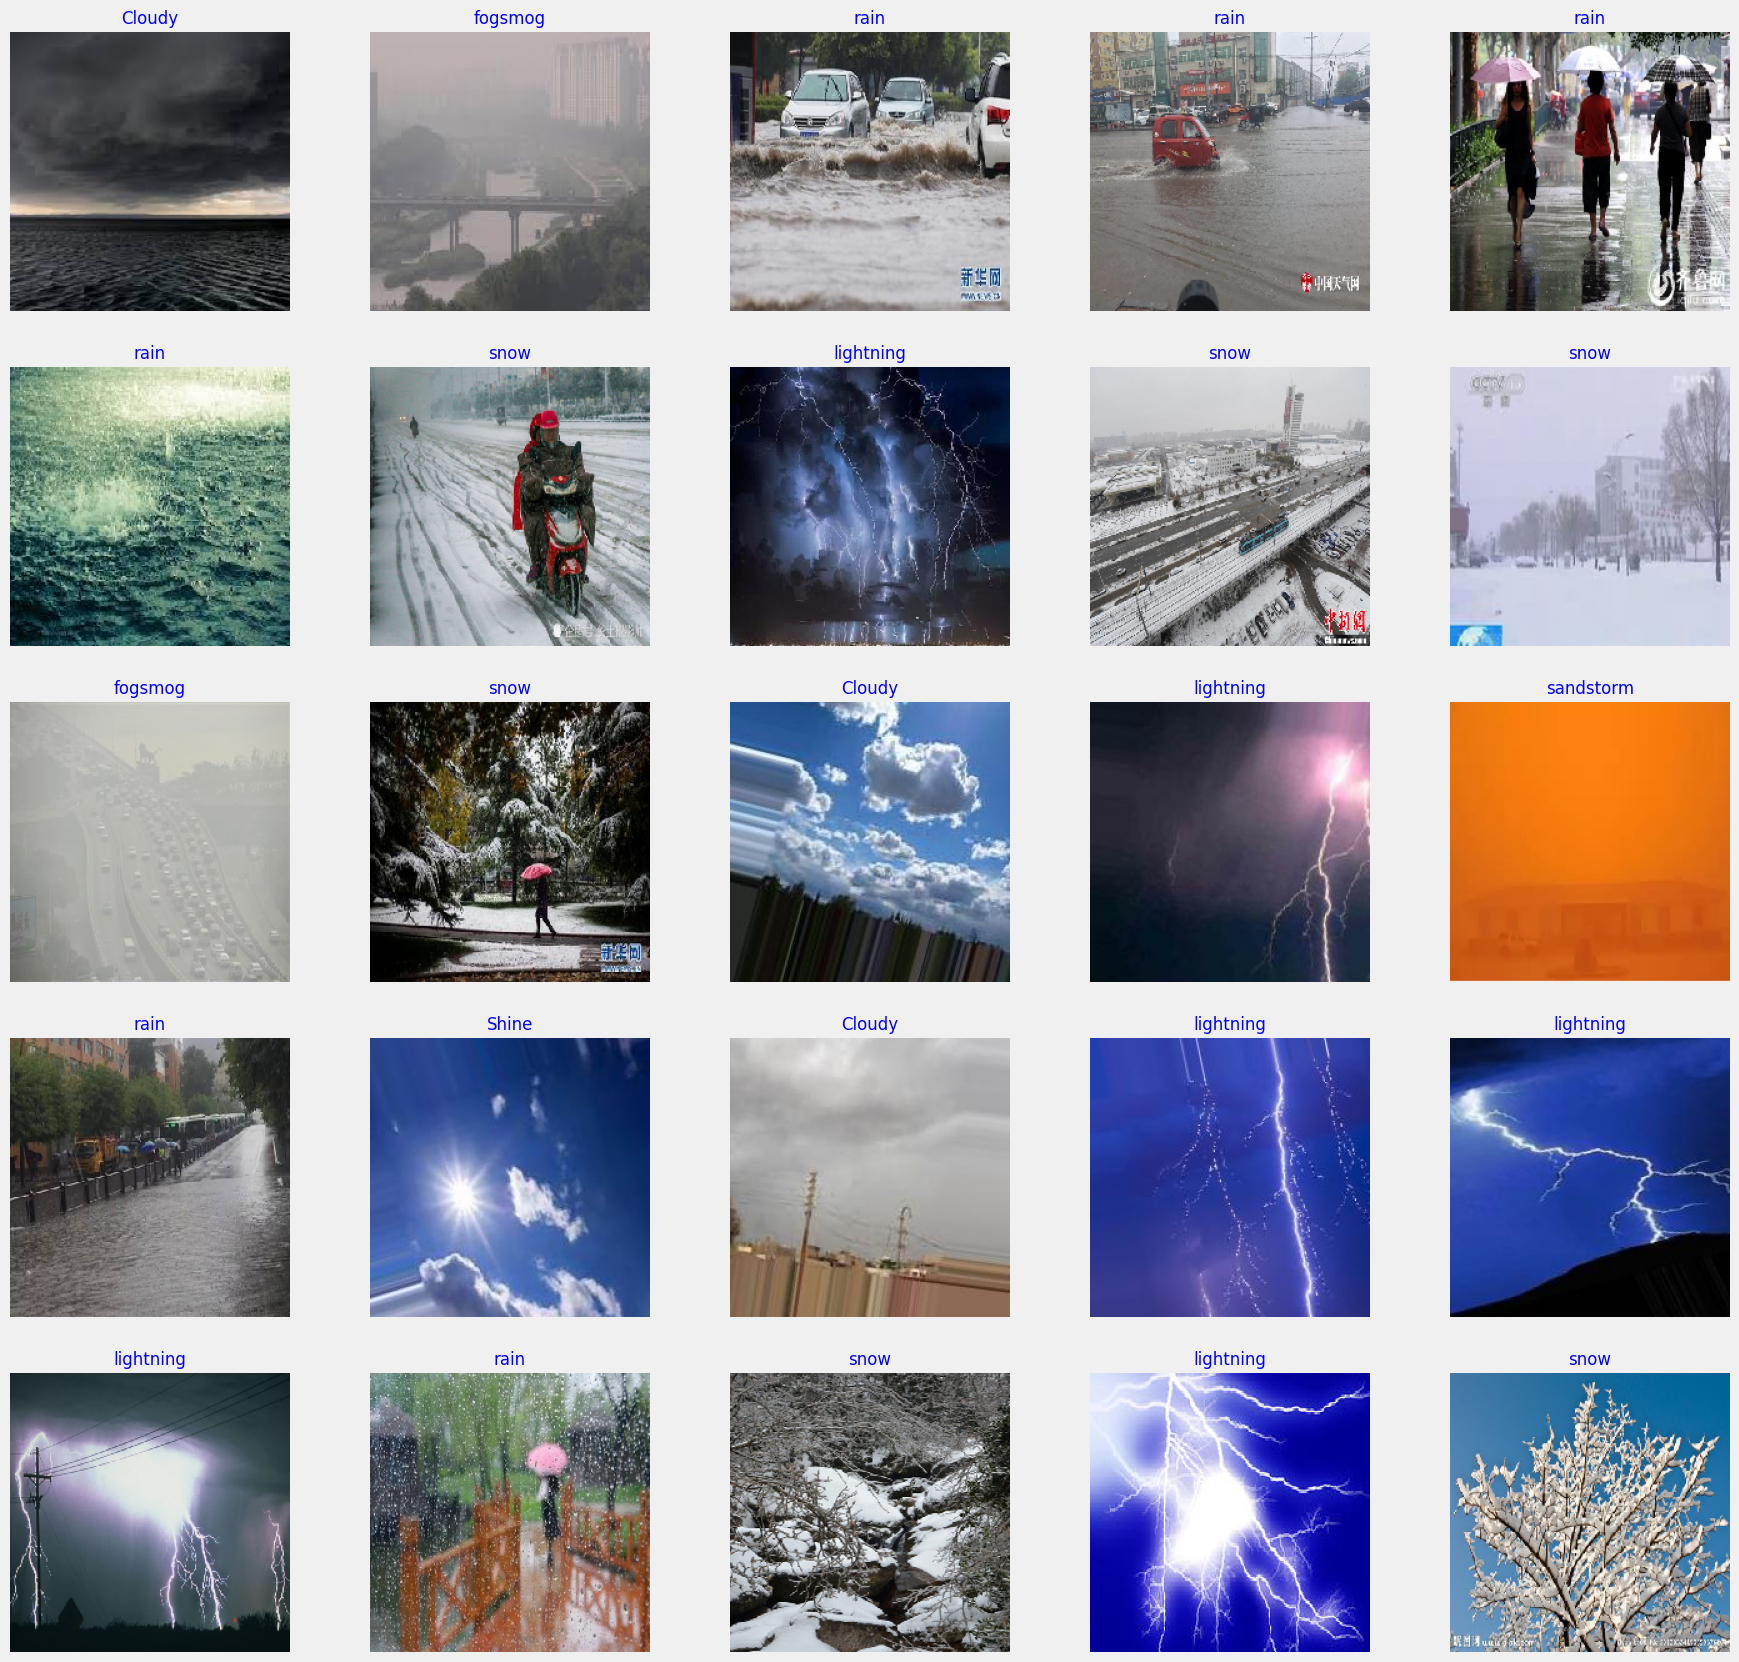

In [31]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# calculate number of displayed samples
length = len(labels)        # length of batch size
sample = min(length, 25)    # check if sample less than 25 images

plt.figure(figsize= (20, 20))
for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [32]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    # First Convolutional Layer
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=img_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Second Convolutional Layer
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Third Convolutional Layer
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Flatten Layer to transition from convolution to dense layers
    Flatten(),

    # Dense Layers
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006)),
    Dropout(0.45, seed=123),
    
    # Output Layer
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 111, 111, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                      

In [33]:
epochs = 5   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/5
55/55 [==============================] - 266s 5s/step - loss: 18.4328 - accuracy: 0.5714 - val_loss: 17.7439 - val_accuracy: 0.3109
Epoch 2/5
55/55 [==============================] - 259s 5s/step - loss: 11.8946 - accuracy: 0.7237 - val_loss: 10.7359 - val_accuracy: 0.6283
Epoch 3/5
55/55 [==============================] - 260s 5s/step - loss: 9.4767 - accuracy: 0.7886 - val_loss: 8.7696 - val_accuracy: 0.6478
Epoch 4/5
55/55 [==============================] - 258s 5s/step - loss: 7.9145 - accuracy: 0.8391 - val_loss: 7.3727 - val_accuracy: 0.7304
Epoch 5/5
55/55 [==============================] - 257s 5s/step - loss: 6.6291 - accuracy: 0.8789 - val_loss: 6.2815 - val_accuracy: 0.7870


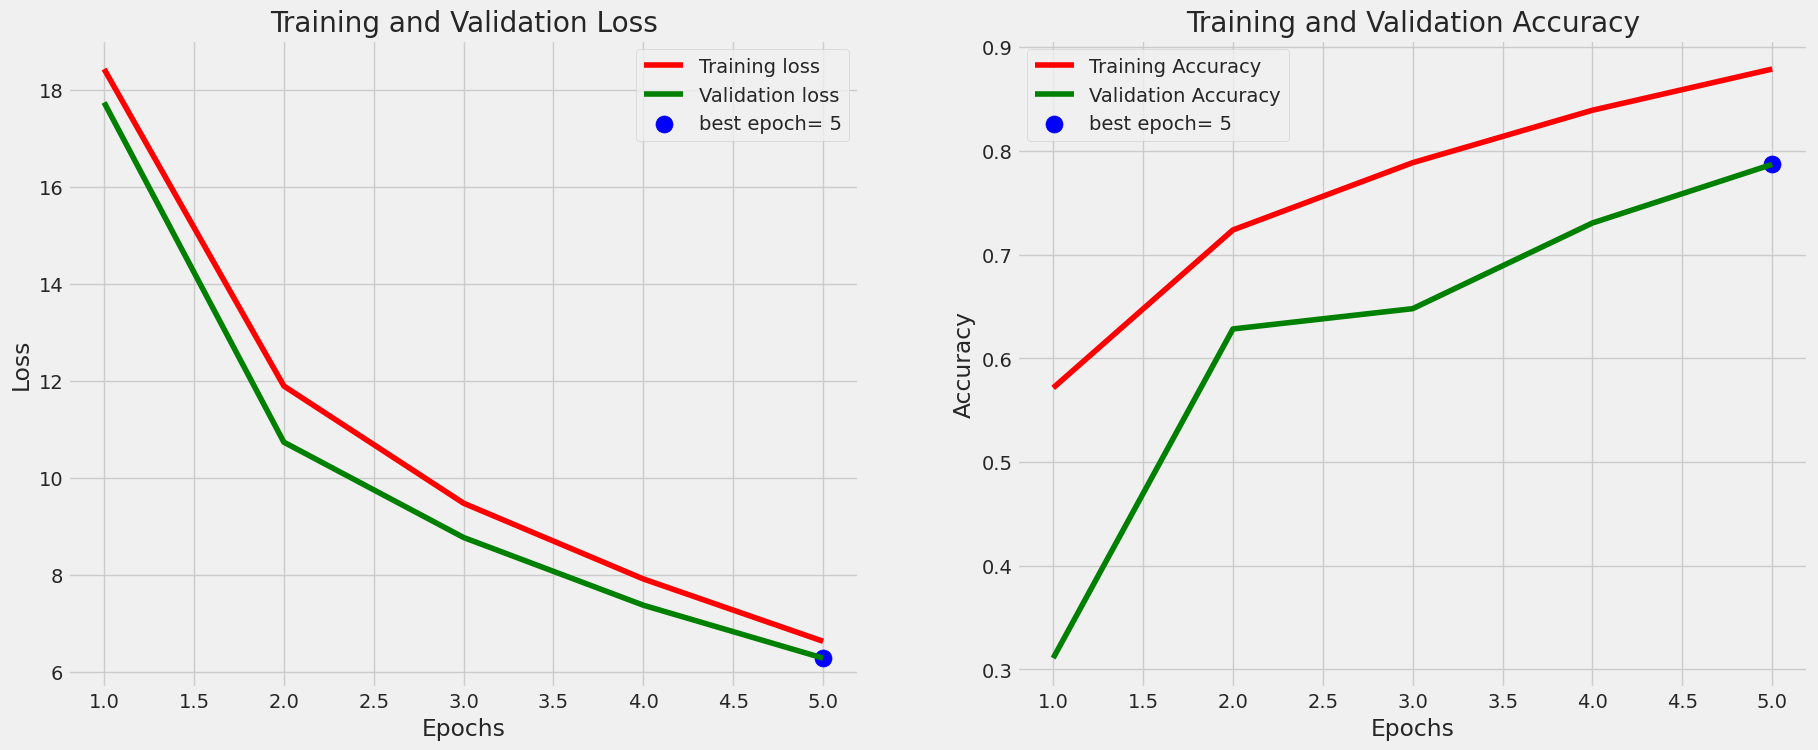

In [34]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [35]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

307/307 [==============================] - 21s 69ms/step - loss: 6.3453 - accuracy: 0.7622
Train Loss:  5.870009899139404
Train Accuracy:  0.9397143125534058
--------------------
Validation Loss:  6.28151273727417
Validation Accuracy:  0.7869565486907959
--------------------
Test Loss:  6.34529972076416
Test Accuracy:  0.7622149586677551


In [36]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

In [37]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      Cloudy       0.63      0.79      0.70        24
       Shine       0.78      0.81      0.79        26
     fogsmog       0.87      0.73      0.80        64
   lightning       0.78      0.89      0.83        28
        rain       0.79      0.54      0.64        63
   sandstorm       0.93      0.84      0.88        50
        snow       0.61      0.88      0.72        52

    accuracy                           0.76       307
   macro avg       0.77      0.78      0.77       307
weighted avg       0.78      0.76      0.76       307

